**Project plan**

*Data preprocessing
1. DONE - Detect the english tweets
https://github.com/rfk/pyenchant

*Sentiment Analysis*
1. Find a sentiment analysis NN to rate last tweets
2. DONE - Extract the emoji's and incorporate the emoji sentiment <br>
https://stackoverflow.com/questions/43852668/using-collections-counter-to-count-emojis-with-different-colors<br>
https://stackoverflow.com/questions/48340622/extract-all-emojis-from-string-and-ignore-fitzpatrick-modifiers-skin-tones-etc

*Build a pipeline for similar tweet recommender*
1. DONE - Implement class for recommend engine
2. DONE - Build a pipeline for word embedding, vectorizing, and recommendation
3. Try out Glove, Google embedding.. etc

*Expansion
1. Narrow down recommendation to resolved tickets
2. Perform 3 types of clustering
3. Perform cluster summarization

In [1]:
import string
import emoji
import regex
import pickle
import re
import enchant
import math
import inflect
import gensim

import numpy as np
import pandas as pd
import vaderSentiment

import matplotlib.pyplot as plt

from itertools import compress
from tqdm import tqdm_notebook
from termcolor import colored


# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF, TruncatedSVD
import nltk.sentiment.vader
from sklearn.neighbors import NearestNeighbors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
    
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize

from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from itertools import cycle
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

%matplotlib inline

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality 

In [2]:
twitter = pd.read_csv("./customer-support-on-twitter/twcs.csv")

# Save original message for future recommendation display
ticket_reserve = twitter[twitter['inbound'] == True]
solution_reserve = twitter[twitter['inbound'] == False]

In [3]:
pd.set_option('display.max_colwidth', -1)

### Exclude tweets with non-English characters

In [45]:
text = '^23'
re.sub(r'^\w+', 'jk', text)

'^23'

In [37]:
twitter.text[170:171].apply(lambda x:clean_text(x, cList))

170     sorry for this. let me request the expert to look into this asap as he is in office. ^raj
Name: text, dtype: object

In [36]:
def fixContractions(text, cList):
    for word in text.split():
        if word.lower() in cList:
            text = text.replace(word, cList[word.lower()])
    return text

def clean_text(text, cList):
    text = text.lower()
    text = text.replace('\n', '')
    text = re.sub(r'https:\/\/t.co\/\w{10}', '', text) # Remove URL link
    text = re.sub(r'@\w+', '', text) # Remove @account
    text = re.sub(r'^\w+', '', text) # Remove @account
    text = fixContractions(text, cList) # Expand contractions
    return text

In [12]:
def get_emoji_free_text(text):
    text = text.replace(u'\u200d', '')
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    if (len(emoji_list) == 0):
        return np.NaN, clean_text
    else:
        return emoji_list, clean_text

In [ ]:
with open('./data/helper/contraction_list.pkl', 'rb') as picklefile:
    cList = pickle.load(picklefile)
twitter['text'] = twitter['text'].apply(lambda x:clean_text(x, cList))
twitter[['emoji','text']] = twitter['text'].apply(lambda x:pd.Series(get_emoji_free_text(x)))

In [123]:
with open('./data/processed/tweets_step1_emoji_extracted.pkl', 'wb')as picklefile:
    pickle.dump(twitter, picklefile)

In [ ]:
with open('./data/processed/tweets_step1_emoji_extracted.pkl', 'rb')as picklefile:
    twitter = pickle.load(picklefile)

### Retrieve sentiment score for emoji's
ref:http://kt.ijs.si/data/Emoji_sentiment_ranking/

In [125]:
def build_dict(emoji_table, emoji_sentiment_dict):
    type_set = set()
    for i in range(emoji_table.shape[0]):
        code = emoji_table.loc[i, 'Python Code']
        try:
            key = chr(int(code[1:], 16))
            emoji_sentiment_dict[key] = emoji_table.loc[i, 'Sentiment score']
        except:
            type_set.add(emoji_table.loc[i, 'Unicode block'])
    return emoji_sentiment_dict

In [127]:
def get_emoji_sentiment(emoji_list):
    score = 0
    if (type(emoji_list) != float):
        for emoji_item in emoji_list:
            if (emoji_item in emoji_sentiment_dict.keys()):
                score += emoji_sentiment_dict[emoji_item]
        if (score == 0):
            return np.NaN
        else:
            return score/len(emoji_list)
    else:
        return np.NaN

In [169]:
emoji_sentiment = pd.read_csv('./data/raw/emoji_nodingbat.csv')
emoji_other = pd.read_csv('./data/raw/emoji_other.csv')
emoji_sentiment_dict = {}

emoji_sentiment_dict = build_dict(emoji_sentiment, emoji_sentiment_dict)
emoji_sentiment_dict = build_dict(emoji_other, emoji_sentiment_dict)

twitter['emoji_score'] = twitter['emoji'].apply(lambda x:get_emoji_sentiment(x))
print ('Number of tweets with emoji score: ', twitter[~twitter['emoji_score'].isnull()].shape[0])
print ('Number of tweets with emoji but not score: ', twitter[twitter['emoji_score'].isnull() & (~twitter['emoji'].isnull())].shape[0])

Number of tweets with emoji score:  161402
Number of tweets with emoji but not score:  33223


In [129]:
with open('./data/processed/tweets_step2_emoji_sentiment.pkl', 'wb')as picklefile:
    pickle.dump(twitter, picklefile)

In [167]:
with open('./data/processed/tweets_step2_emoji_sentiment.pkl', 'rb')as picklefile:
    twitter = pickle.load(picklefile)

### Remove non-English tweets

In [170]:
# Retrieve elements that are printable in English context - This is a 
# combination of digits, letters, punctuation, and whitespace.
valid_content = set(string.printable)

# Include some common non-English punctuations
non_English_punctuation = ['‘', '’', 'é', '–','—','“','”','、','。','`','️', '£', '…', '$']

# Keep tweets with common non-English punctuations
[valid_content.add(x) for x in (non_English_punctuation)]
    
def isEnglish(tweet):
    invalid_index = [x not in valid_content for x in tweet]
    if (np.sum(invalid_index)==0):
        return True
    else:
        return False

## Removed 78k tweets with non-English characters
english_tweets = twitter.text.apply(lambda x:isEnglish(x))
tweets = twitter.loc[english_tweets, :]

In [171]:
# A quick tool to return non-English words
def non_English(words):
    print (list(compress(list(words), [x not in valid_content for x in words])))

### Format the dates

In [173]:
# Format the dates
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [174]:
tweets['in_response_to_tweet_id'] = tweets['in_response_to_tweet_id'].fillna(-1)
tweets['in_response_to_tweet_id'] = tweets['in_response_to_tweet_id'].astype(int)
tweets['response_tweet_id'] = tweets['response_tweet_id'].fillna(-1)

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [175]:
with open('./data/processed/tweets_step3_english.pkl', 'wb')as picklefile:
    pickle.dump(tweets, picklefile)

In [176]:
with open('./data/processed/tweets_step3_english.pkl', 'rb')as picklefile:
    tweets = pickle.load(picklefile)

### Add custom_id and brand_id columns

In [198]:
# Add custom_id column
tweets = pd.merge(tweets,pd.DataFrame(tweets[['tweet_id', 'author_id']]),left_on='in_response_to_tweet_id', right_on='tweet_id', how='left')
tweets.loc[tweets['inbound'] == True, 'author_id_y'] = tweets.loc[tweets['inbound'] == True, 'author_id_x']
tweets['author_id_y'] = tweets['author_id_y'].fillna(-1)
tweets.drop('tweet_id_y', axis=1, inplace=True)
tweets.rename(columns={'author_id_y':'cust_id', 
                       'author_id_x':'author_id',
                      'tweet_id_x':'tweet_id'}, inplace=True)

# Drop the tweets without customer id, those are usually promotional tweets initiated by
# brands agent or customers not in the datase: Number of such tweets: 71255
tweets = tweets[~tweets['cust_id'].isnull()]

In [227]:
# Add brand_id column

# Carve out the first tweet id when there are multiples in response_tweet_id
tweets['processed_response_id'] = tweets['response_tweet_id'].apply(
    lambda x: x if (isinstance(x,int)) else x.split(',')[0])
tweets['processed_response_id'] = tweets['processed_response_id'].astype(int)

# Retrieve the author id of the responde tweet
tweets = pd.merge(tweets,pd.DataFrame(tweets[['tweet_id', 'author_id']]),
                  left_on='processed_response_id', 
                  right_on='tweet_id', 
                  how='left')

tweets.drop('tweet_id_y', axis=1, inplace=True)
tweets.rename(columns={'author_id_y':'brand_id', 
                       'author_id_x':'author_id',
                      'tweet_id_x':'tweet_id'}, inplace=True)

tweets = pd.merge(tweets,pd.DataFrame(tweets[['tweet_id', 'author_id']]),left_on='in_response_to_tweet_id', right_on='tweet_id', how='left')
tweets.loc[(tweets['inbound'] & (tweets['processed_response_id'] == -1)), 'brand_id'] = (
    tweets.loc[(tweets['inbound'] & (tweets['processed_response_id'] == -1)), 'author_id_y'])
tweets.rename(columns={'tweet_id_x':'tweet_id', 
                       'author_id_x':'author_id'}, inplace=True)

tweets.loc[tweets['inbound'] == False, 'brand_id'] = tweets.loc[tweets['inbound'] == False, 'author_id']
tweets.drop(['processed_response_id', 'tweet_id_y', 'author_id_y'], axis=1, inplace=True)

# could use some more logic to extract the account name in tweet text

In [233]:
# Tweets with no response is 3880
print (tweets[tweets['brand_id'].isnull() & (tweets['response_tweet_id'] == -1)].shape)

# Tweets with response outside the dataset is 42764
print (tweets[tweets['brand_id'].isnull() & (tweets['response_tweet_id'] != -1)].shape)

# Drop the tweets without brand_id
tweets = tweets[~tweets['brand_id'].isnull()]

In [6]:
# Identify which tweets are in the same conversation (customer case)
tweets.sort_values(['cust_id', 'created_at'], inplace=True)
tweets.reset_index(inplace=True)

# Calculate the time difference (in seconds) bwetween a tweet and its previous tweet
tweets['time_diff'] = tweets['created_at'].diff()
tweets['time_diff'] = tweets['time_diff'].apply(lambda x:x.total_seconds())
tweets['time_diff'] = tweets['time_diff'].apply(lambda x: 0 if x <0 else x)
tweets['time_diff'] = tweets['time_diff'].fillna(0)

tweets['case_id'] = 0
tweets['time_diff'] = tweets['time_diff'].fillna(0) 

In [ ]:
with open('./data/processed/tweets_step4_brand_cust.pkl', 'wb')as picklefile:
    pickle.dump(tweets, picklefile)

In [ ]:
with open('./data/processed/tweets_step4_brand_cust.pkl', 'rb')as picklefile:
    tweets = pickle.load(picklefile)

### Carve out the support data for a particular brand

In [7]:
def analyze_brand(tweets, brand_cc_name):
    ## Subset tweets according to brand
    brand = tweets[tweets['brand_id'] == brand_cc_name]
    brand.reset_index(inplace=True)
    
    ## Assign unique caseid for each conversation (interchange of tweets)
    ## To avoid grouping different cases raised by the same customer at different time
    ## We set the max threshold between subsequent tweets in a conversation as 2 days
    caseid = 1
    brand.loc[0, 'case_id'] = caseid
    for row in range(1, brand.shape[0]):
        if (row%1000 == 0):
            print (row)
        if ((brand.loc[row, 'cust_id'] != brand.loc[row-1, 'cust_id']) |
            (brand.loc[row, 'time_diff'] > 3600*24*2)):
            caseid = caseid + 1
            brand.loc[row, 'time_diff'] = 0 # Set time between conversations as 0
            brand.loc[row, 'case_id'] = caseid
        else:
            brand.loc[row, 'case_id'] = caseid
    return brand

In [8]:
# CAUTION! This function takes SUPER LONG TIME to run, 80k row takes 3 hours!
spotify = analyze_brand(tweets, 'SpotifyCares')

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000


In [9]:
with open('./data/processed/spotify.pkl', 'wb')as picklefile:
    pickle.dump(spotify, picklefile)

In [3]:
with open('./data/processed/spotify.pkl', 'rb')as picklefile:
    spotify = pickle.load(picklefile)

### Remove ticket without solution and solution without ticket

In [4]:
conv_count = spotify.groupby('case_id')['case_id'].count()
single_conv_index = conv_count[conv_count==1].index.tolist()
spotify['single_conv'] = spotify['case_id'].apply(
    lambda x: True if x in single_conv_index else False)

# Remove the conversations with only one tweet (424 ) 
spotify = spotify[~spotify['single_conv']]
spotify.drop('single_conv', axis=1, inplace=True)

spotify.drop(['level_0', 'index'], axis=1, inplace=True)

In [5]:
ticket = spotify[spotify['inbound'] == True]
solution = spotify[spotify['inbound'] == False]

In [10]:
print (len(ticket.case_id.unique()))
len(solution.case_id.unique())

28796


28794

In [11]:
# Remove ticket without solution or solution without ticket 
# conversations with tweets from only customer or customer agents

ticket = ticket.apply(
    lambda x: x if (x[12] in solution['case_id'].unique()) else None, axis = 1)
solution = solution.apply(
    lambda x: x if (x[12] in ticket['case_id'].unique()) else None, axis = 1)

In [14]:
ticket[['tweet_id', 'text', 'case_id']]

,tweet_id,text,case_id
0,2747480.0,uh why is there a limit on how many songs i ca...,1.0
2,2747479.0,cool cool cool i think i am finally ready to s...,1.0
4,2606352.0,there used to be a useful feature in ios app t...,2.0
6,2606351.0,taking features away will only make it easier ...,2.0
8,855.0,i’m pissed my shuffle and repeat button just d...,3.0
10,853.0,iphone 7+ and i have the most recent update fo...,3.0
12,850.0,premium &amp; when i️ have it on shuffle it tu...,3.0
14,849.0,doesn’t work and i even tried deleting the app,3.0
16,862.0,groove music quits &amp; redirect to spotify. ...,4.0
18,861.0,version is 5.2.4.0. 7 of 10 app starts it says...,4.0


In [15]:
#ticket.text.fillna('', inplace=True)
#solution.text.fillna('', inplace=True)
ticket_agg = ticket.groupby('case_id')['text'].agg(lambda x:' '.join(x))
solution_agg = solution.groupby('case_id')['text'].agg(lambda x:' '.join(x))

In [ ]:
spotify = spotify.apply(
    lambda x: x if (x[10] in ticket['case_id'].unique()) else None, axis=1)

In [29]:
with open('./data/processed/ticket.pkl', 'wb')as picklefile:
    pickle.dump(ticket, picklefile)
with open('./data/processed/solution.pkl', 'wb')as picklefile:
    pickle.dump(solution, picklefile)
with open('./data/processed/ticket_agg.pkl', 'wb')as picklefile:
    pickle.dump(ticket_agg, picklefile)
with open('./data/processed/solution_agg.pkl', 'wb')as picklefile:
    pickle.dump(solution_agg, picklefile)

### Perform very basic sentiment analysis on last tweet from customer

In [54]:
cust_last_tweet = ticket.groupby('case_id')[['text','emoji', 'emoji_score']].last().reset_index()

In [55]:
vdanalyzer = vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer()
cust_last_tweet['vader_sentiment'] = cust_last_tweet['text'].apply(
        lambda x:vdanalyzer.polarity_scores(x)['compound'])

In [56]:
sentiment_analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()
cust_last_tweet['ntlk_sentiment'] = cust_last_tweet['text'].apply(
        lambda x:sentiment_analyzer.polarity_scores(x)['compound'])

In [58]:
cust_last_tweet.to_csv('./data/processed/processed_last_tweet_sentiment.csv', index=False)

In [60]:
cust_last_tweet = pd.read_csv('./data/processed/processed_last_tweet_sentiment.csv', index_col=None)

In [63]:
def get_overall_sentiment_score(row):
    sentiment = ''
    if (not math.isnan(row[3])):
        if (row[3] >= 0.2):
            sentiment = 'POS'
        elif ((row[3] < 0.2) & (row[3] > -0.05)):
            sentiment = 'NEU'
        elif (row[3] <= -0.05):
            sentiment = 'NEG'
    elif (not math.isnan(row[5])):
        if (row[5] >= 0.2):
            sentiment = 'POS'
        elif ((row[5] < 0.2) & (row[5] > -0.05)):
            sentiment = 'NEU'
        elif (row[5] <= -0.05):
            sentiment = 'NEG'
    return sentiment

In [64]:
cust_last_tweet[['emoji_score', 'ntlk_sentiment']] = cust_last_tweet[['emoji_score', 'ntlk_sentiment']].astype(float)
cust_last_tweet['sentiment'] = cust_last_tweet.apply(lambda
                        x:get_overall_sentiment_score(x), axis=1)

In [67]:
cust_last_tweet.to_csv('./data/processed/processed_last_tweet_sentiment.csv', index=False)

In [68]:
cust_last_tweet = pd.read_csv('./data/processed/processed_last_tweet_sentiment.csv', index_col=None)

In [70]:
spotify = pd.merge(spotify, cust_last_tweet[['case_id', 'sentiment']],
                   left_on='case_id', right_on='case_id',
                   how='left')

In [73]:
with open('./data/processed/tweets_step5_spotify_sentiment.pkl', 'wb')as picklefile:
    pickle.dump(spotify, picklefile)

In [17]:
with open('./data/processed/tweets_step5_spotify_sentiment.pkl', 'rb')as picklefile:
    spotify = pickle.load(picklefile)

### Tweets preprocessing

In [4]:
custom_stopwords = ['http', 'https', 'spotify', 'help', 'hi', 'spotifycares']
my_stop_words = (text.ENGLISH_STOP_WORDS.union(custom_stopwords)
                 .union(string.punctuation))

In [19]:
df_ticket = pd.DataFrame(ticket_agg)
df_ticket.reset_index(inplace=True)

In [20]:
df_solution = pd.DataFrame(solution_agg)
df_solution.reset_index(inplace=True)

In [22]:
cust_last_tweet = pd.read_csv('./data/processed/processed_last_tweet_sentiment.csv', index_col=None)

In [23]:
df_ticket = pd.merge(df_ticket, cust_last_tweet[['case_id', 'sentiment']], left_on='case_id', right_on='case_id',
                   how='left')

In [24]:
def text_preprocess(text):
    tokens = word_tokenize(text)
    lemmatize = WordNetLemmatizer()
    clean_text = [lemmatize.lemmatize(token.lower().strip(), pos='a') for token in tokens]
    clean_text = [x for x in clean_text if x not in my_stop_words]
    return ' '.join(clean_text)

In [25]:
df_ticket['text'] = df_ticket.text.apply(lambda x:text_preprocess(x))

In [26]:
with open('./data/processed/tweets_step6_ticket_preprocessed.pkl', 'wb')as picklefile:
    pickle.dump(df_ticket, picklefile)

### Build recommendation engines

In [3]:
## Read in files from previous steps
with open('./data/processed/tweets_step6_ticket_preprocessed.pkl', 'rb')as picklefile:
    df_ticket = pickle.load(picklefile)

cust_last_tweet = pd.read_csv('./data/processed/processed_last_tweet_sentiment.csv', index_col=None)

with open('./data/processed/ticket.pkl', 'rb')as picklefile:
    ticket = pickle.load(picklefile)

with open('./data/processed/solution.pkl', 'rb')as picklefile:
    solution = pickle.load(picklefile)
    
with open('./data/processed/ticket_agg.pkl', 'rb')as picklefile:
    ticket_agg = pickle.load(picklefile)

with open('./data/processed/solution_agg.pkl', 'rb')as picklefile:
    solution_agg = pickle.load(picklefile)
'''
with open('./data/processed/engines.pkl', 'rb') as picklefile:
    engines = pickle.load(picklefile)

engine_1 = engines[1]
engine_2 = engines[2]
engine_3 = engines[3]
'''    

"\nwith open('./data/processed/engines.pkl', 'rb') as picklefile:\n    engines = pickle.load(picklefile)\n\nengine_1 = engines[1]\nengine_2 = engines[2]\nengine_3 = engines[3]\n"

In [4]:
custom_stopwords = ['http', 'https', 'spotify', 'help', 'hi', 'spotifycares']
my_stop_words = (text.ENGLISH_STOP_WORDS.union(custom_stopwords)
                 .union(string.punctuation))

In [7]:
with open('./data/processed/engines.pkl', 'rb') as picklefile:
    engines = pickle.load(picklefile)

engine_1 = engines[1]
engine_2 = engines[2]
engine_3 = engines[3]

AttributeError: Can't get attribute 'RecommendationEngine' on <module '__main__'>

In [5]:
class RecommendationEngine:
    def __init__(self, vectorizer, n_components, reducer, ticket, solution):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        self.ticket = ticket
        self.solution = solution
        
    def fit(self, df):
        self.vector_data = self.vectorizer.fit_transform(df['text'])
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.df = df_ticket
    
    def _print_recommendations(self, article, rec_list):
        p = inflect.engine()
        print('NEW MESSAGE:', article)
        i = 1
        for resp in self.df.loc[rec_list]['case_id']:
            print(f'\n---{p.ordinal(i)} SIMILAR CONVERSATION---\n')
            self._display_conversation(resp)
            print('\n')
            i += 1
    
    def _display_conversation (self, case_id):
        cust_conv = self.ticket[self.ticket['case_id'] == case_id][['created_at', 'inbound', 'text']]
        agent_conv = self.solution[self.solution['case_id'] == case_id][['created_at', 'inbound', 'text']]
        conv_list = pd.concat([cust_conv, agent_conv]).sort_values('created_at')
        for i in range(conv_list.shape[0]):
            if (conv_list.iloc[i]['inbound']):
                print ('CUSTOMER:   ', colored(conv_list.iloc[i]['text'], 'red'))
            else:
                print ('AGENT:      ', colored(conv_list.iloc[i]['text'], 'green'))
        
    def recommend(self, article, num_to_return):
        article_vectorized = self.vectorizer.transform([article])
        article_topic_vector = self.reducer.transform(article_vectorized)
        nn = NearestNeighbors(n_neighbors=num_to_return, metric='cosine', algorithm='brute')
        
        tmp = self.vectorizer.transform(self.df[self.df['sentiment']=='POS'].text)
        tmp2 = self.reducer.transform(tmp)
        
        nn.fit(tmp2)
        results = nn.kneighbors(article_topic_vector)
        #result_texts = [self.texts[i] for i in results[1][0]]
        rec_list = results[1][0]
        print ('number of results: ', len(rec_list))
        self._print_recommendations(article, rec_list)
        
        return rec_list
    
    def display_topics(self, no_top_words, topic_names=None):
        feature_names = self.vectorizer.get_feature_names()
        for ix, topic in enumerate(self.reducer.components_):
            if not topic_names or not topic_names[ix]:
                print("\nTopic ", ix)
            else:
                print("\nTopic: '",topic_names[ix],"'")
            print(", ".join([feature_names[i]
                for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
ticket_origin = pd.merge(ticket_reserve[['tweet_id', 'created_at', 'inbound', 'text']], ticket[['tweet_id', 'case_id']], left_on='tweet_id', right_on='tweet_id', how='right')
solution_origin = pd.merge(solution_reserve[['tweet_id', 'created_at', 'inbound', 'text']], solution[['tweet_id', 'case_id']], left_on='tweet_id', right_on='tweet_id', how='right')

In [7]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)


#tfidf_data = tfidf_vectorizer.fit_transform(list(df_ticket.text))

In [8]:
tfidf_data = tfidf_vectorizer.fit_transform(list(df_ticket.text))
lsa_tfidf = TruncatedSVD(n_components=50)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)

In [56]:
engine_1 = RecommendationEngine(tfidf_vectorizer, n_components = 20, reducer = TruncatedSVD, ticket = ticket_origin, solution=solution_origin)
topic_data = engine_1.fit(df_ticket)

In [57]:
engine_2 = RecommendationEngine(count_vectorizer, n_components = 20, reducer = NMF, ticket = ticket_origin, solution=solution_origin)
engine_2.fit(df_ticket)

In [58]:
engine_3 = RecommendationEngine(tfidf_vectorizer, n_components = 20, reducer = NMF, ticket = ticket_origin, solution=solution_origin)
engine_3.fit(df_ticket)

In [60]:
engine_dict = {1:engine_1, 2:engine_2, 3:engine_3}

In [61]:
with open('./data/processed/engines.pkl', 'wb') as picklefile:
    pickle.dump(engine_dict, picklefile)

In [63]:
cust_first_tweet = ticket.groupby('case_id')[['text']].first().reset_index()
sample = cust_first_tweet.text[np.random.choice(cust_first_tweet.shape[0])]

In [77]:
index = 7

In [78]:
engine_1.recommend(cust_first_tweet.text[index], 3)

number of results:  3
NEW MESSAGE: why are my devices not doing the cool thing when i play the #strangerthings albums on ?

---1st SIMILAR CONVERSATION---

CUSTOMER:    @115888 @126761 @SpotifyCares can you add JLo's song Amor Amor Amor to this playlist https://t.co/BifyTOMt54
AGENT:       @207448 Hey! Our Curation team are independent &amp; use taste, data, research, and trends to create playlists, but we’ll pass on your suggestion /GU



---2nd SIMILAR CONVERSATION---

CUSTOMER:    @115888 is it possible to get a discount on Spotify Premium for Family by paying for a whole year all at once?
AGENT:       @262532 Hi Andy! Right now, it isn't possible to sign up for a full year of Premium for Family, but you can sign up for the Annual Discount then upgrade to Premium for Family. Note that this will move your renewal date forward due to the difference in pricing. Hope this helped 🙂 /DB



---3rd SIMILAR CONVERSATION---

CUSTOMER:    @SpotifyCares hey, I already sent you a dm, I'm having 

array([3257, 5458, 3288])

In [70]:
engine_1.display_topics(10)


Topic  0
account, premium, family, student, just, need, email, premium account, app, thanks

Topic  1
account, premium, student, premium account, charged, email, family, hulu, facebook, hacked

Topic  2
dm, sent, sent dm, need, check, check dm, thanks, account, email, thank

Topic  3
premium, dm, student, charged, family, discount, sent, student discount, month, sent dm

Topic  4
app, iphone, update, student, charged, dm, app iphone, discount, update app, student discount

Topic  5
need, reputation, student, charged, thank, album, discount, student discount, available, hulu

Topic  6
need, family, iphone, app, update, premium, plan, family plan, need account, app iphone

Topic  7
reputation, iphone, update, thank, app, available, reputation available, app iphone, update app, family

Topic  8
thank, need, family, thank thank, dm thank, iphone, plan, account thank, thank guys, family plan

Topic  9
thanks, student, family, plan, email, family plan, discount, student discount, charged, u

In [71]:
engine_2.recommend(cust_first_tweet.text[index], 3)

number of results:  3
NEW MESSAGE: there used to be a useful feature in ios app that allowed user to hear sample of song by touch+hold on song. gone?

---1st SIMILAR CONVERSATION---

CUSTOMER:    @SpotifyCares My account suddenly logged me out on all devices, won't let me reset my  password and says account no longer exists... Any ideas on why this is?
AGENT:       @226669 Hi there! That doesn't sound good. Can you DM us your account's username or email address? We'll take a look under the hood /DN https://t.co/ldFdZRiNAt



---2nd SIMILAR CONVERSATION---

CUSTOMER:    @115888 @SpotifyCares
AGENT:       @379150 Hey there! We'd love to have it on Spotify, but there's info about content here: https://t.co/0i8GpimuDa /KB
CUSTOMER:    @SpotifyCares there’s no content warning put it on or i’m leaving your app
AGENT:       @379150 We hear you. Rest assured, your feedback will be passed on to the right folks /NS



---3rd SIMILAR CONVERSATION---

CUSTOMER:    hey @115888 why isn’t spotify pre

array([ 3977,  9975, 10838])

In [72]:
engine_3.recommend(cust_first_tweet.text[index], 3)

number of results:  3
NEW MESSAGE: there used to be a useful feature in ios app that allowed user to hear sample of song by touch+hold on song. gone?

---1st SIMILAR CONVERSATION---

CUSTOMER:    Why is Here we go again - Trina ft Kelly rowland not on @115888 yet 🙄 gummmoonnn
AGENT:       @413410 Hi there, we're here to help. What country is your account set to? We'll take a look backstage /AK
CUSTOMER:    @SpotifyCares New Zealand .
AGENT:       @413410 Thanks. Fingers crossed we'll be able to have it soon, but there's info about Spotify content here: https://t.co/0i8GpimuDa /AK



---2nd SIMILAR CONVERSATION---

CUSTOMER:    @SpotifyCares why do my playlists say "by Spotify" all of a sudden? I can't add/edit anymore. Don't want to re-make them. #spotify #help
AGENT:       @334796 Hey Anahid! Can you send us the link to the playlist that you're trying to edit? Just tap the three dots &gt; Share &gt; Copy Link /MG
CUSTOMER:    @SpotifyCares It's happened to all my playlists but here's 

array([11295,  8434,  6286])

### Try word2vec model

In [29]:
# Function to take a document as a list of words and return the document vector
def get_doc_vec(words, model):
    good_words = []
    for word in words:
        # Words not in the original model will fail
        try:
            if model.wv[word] is not None:
                good_words.append(word)
        except:
            continue
    # If no words are in the original model
    if len(good_words) == 0:
        return [0.0]*300
    # Return the mean of the vectors for all the good words
    return model.wv[good_words].mean(axis=0)

In [30]:
google_vec_file = '~/Downloads/GoogleNews-vectors-negative300.bin'
google_model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [31]:
def print_recommendations(df, article, rec_list):
    p = inflect.engine()
    print('NEW MESSAGE:', article)
    i = 1
    for resp in df.loc[rec_list]['case_id']:
        print(f'\n---{p.ordinal(i)} SIMILAR CONVERSATION---\n')
        display_conversation(resp)
        print('\n')
        i += 1

def display_conversation (case_id):
    cust_conv = ticket[ticket['case_id'] == case_id][['created_at', 'inbound', 'text']]
    agent_conv = solution[solution['case_id'] == case_id][['created_at', 'inbound', 'text']]
    conv_list = pd.concat([cust_conv, agent_conv]).sort_values('created_at')
    for i in range(conv_list.shape[0]):
        if (conv_list.iloc[i]['inbound']):
            print ('CUSTOMER:   ', colored(conv_list.iloc[i]['text'], 'red'))
        else:
            print ('AGENT:      ', colored(conv_list.iloc[i]['text'], 'green'))

In [32]:
def recommend_word2vec(df, model, num_to_return, article):
    tmp = df[df['sentiment']=='POS'].text
    ticket_google_vecs = tmp.map(lambda x: get_doc_vec(x.split(), model))
    df_ticket_google = pd.DataFrame(ticket_google_vecs.values.tolist())
    nn = NearestNeighbors(n_neighbors=num_to_return, metric='cosine', algorithm='brute')
    nn.fit(df_ticket_google)
    new_vecs = get_doc_vec(article.split(), model)
    tmp2 = pd.DataFrame([new_vecs.tolist()])
    rec_list = nn.kneighbors(tmp2)[1][0].tolist()
    
    print_recommendations(df, article, rec_list)
    return 

In [92]:
recommend_word2vec(df_ticket, google_model, 3, cust_first_tweet.text[index])

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


NEW MESSAGE: why are my devices not doing the cool thing when i play the #strangerthings albums on ?

---1st SIMILAR CONVERSATION---

CUSTOMER:    any plans to improve queue functionality? (queuing on web player, clearing queue on android)
AGENT:       hey there! we do not have any info on this right now, but we will let the right team know it is something you had like to see /mx



---2nd SIMILAR CONVERSATION---

CUSTOMER:    anyone else's just randomly stop and close on #android. it is daily on my #galaxys8. so annoying. , can you shed light?
AGENT:       hey dan, help's here! could you dm us your device, operating system, and spotify version? we will take a look /q



---3rd SIMILAR CONVERSATION---

CUSTOMER:    i just paid for premium service via your webpage with facebook login yet my account is still showing only free service.
AGENT:       hey marcy, we are here to help! could you dm us your account's email address? we will take a look backstage /bx




In [35]:
tmp = df_ticket[df_ticket['sentiment']=='POS'].text
ticket_google_vecs = tmp.map(lambda x: get_doc_vec(x.split(), google_model))
df_ticket_google = pd.DataFrame(ticket_google_vecs.values.tolist())

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [38]:
df_ticket_google.shape

(11981, 300)

### Perform Clustering

### DBSCAN

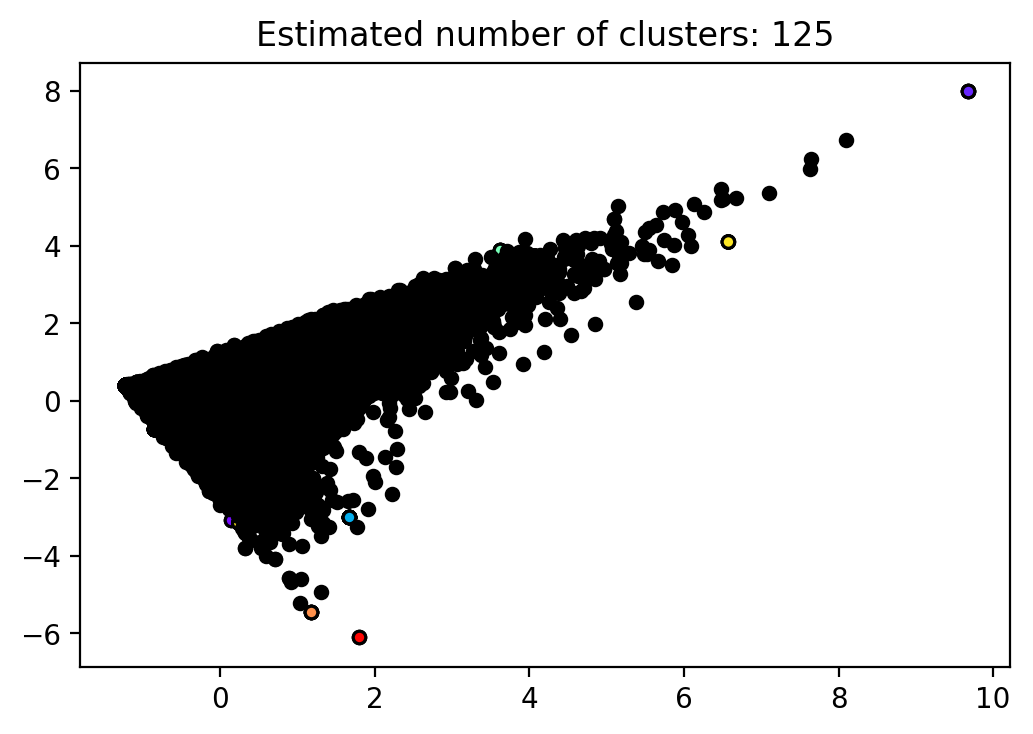

In [239]:
X = StandardScaler().fit_transform(lsa_tfidf_data)
db = DBSCAN(eps=0.15, min_samples=3).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1)
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

### Mean Shift

In [237]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(lsa_tfidf_data, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 18211


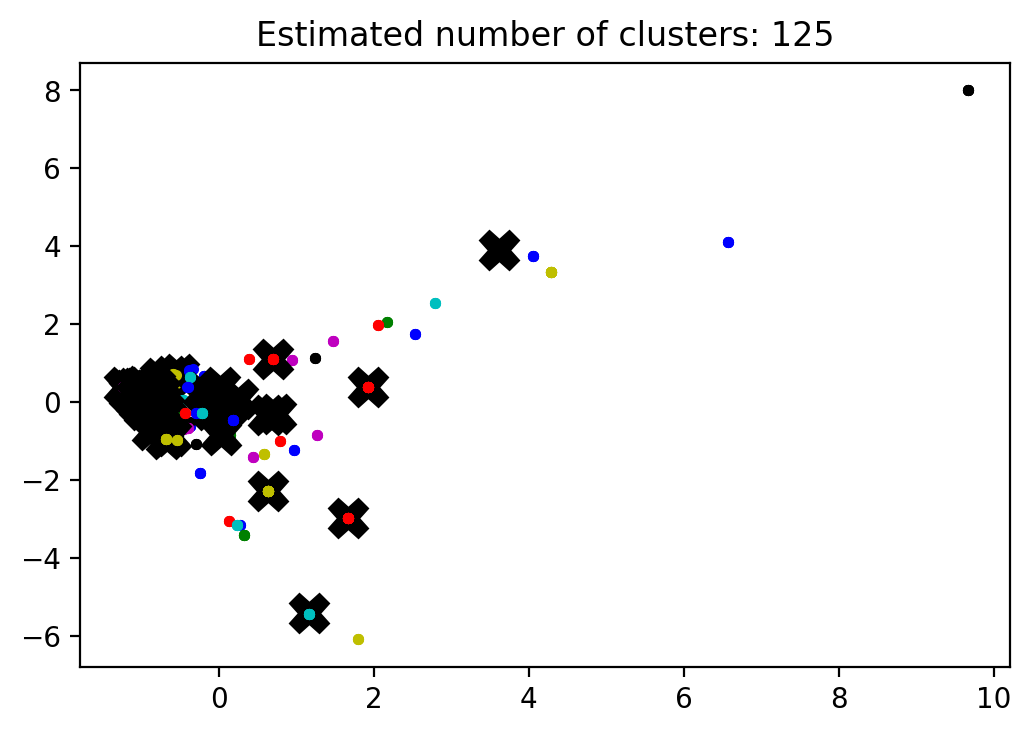

In [240]:


plt.figure(1)
plt.clf()
plt.figure(dpi=200)
colors = cycle('byrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'X', markerfacecolor='k',
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_);

### KMeans

In [13]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

In [9]:
lsa_tfidf_data.shape

(28787, 50)

In [42]:
SSEs = []
Sil_coefs = []
X = StandardScaler().fit_transform(lsa_tfidf_data)
for k in range(2,100,4):
    print ('clustering trial:', k)
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    labels = km.labels_
    #Sil_coefs.append(metrics.silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(get_SSE(X, labels)) # The SSE is just inertia, we could have just said km.inertia_

clustering trial: 2
clustering trial: 6
clustering trial: 10
clustering trial: 14
clustering trial: 18
clustering trial: 22
clustering trial: 26
clustering trial: 30
clustering trial: 34
clustering trial: 38
clustering trial: 42
clustering trial: 46
clustering trial: 50
clustering trial: 54
clustering trial: 58
clustering trial: 62
clustering trial: 66
clustering trial: 70
clustering trial: 74
clustering trial: 78
clustering trial: 82
clustering trial: 86
clustering trial: 90
clustering trial: 94
clustering trial: 98


In [43]:
google_SSEs = []
google_X = StandardScaler().fit_transform(df_ticket_google)
for k in range(2,100,4):
    print ('clustering trial:', k)
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(google_X)
    labels = km.labels_
    #Sil_coefs.append(metrics.silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    google_SSEs.append(get_SSE(google_X, labels)) # The SSE is just inertia, we could have just said km.inertia_

clustering trial: 2
clustering trial: 6
clustering trial: 10
clustering trial: 14
clustering trial: 18
clustering trial: 22
clustering trial: 26
clustering trial: 30
clustering trial: 34
clustering trial: 38
clustering trial: 42
clustering trial: 46
clustering trial: 50
clustering trial: 54
clustering trial: 58
clustering trial: 62
clustering trial: 66
clustering trial: 70
clustering trial: 74
clustering trial: 78
clustering trial: 82
clustering trial: 86
clustering trial: 90
clustering trial: 94
clustering trial: 98


Text(0.5,1,'SSE vs Clusters')

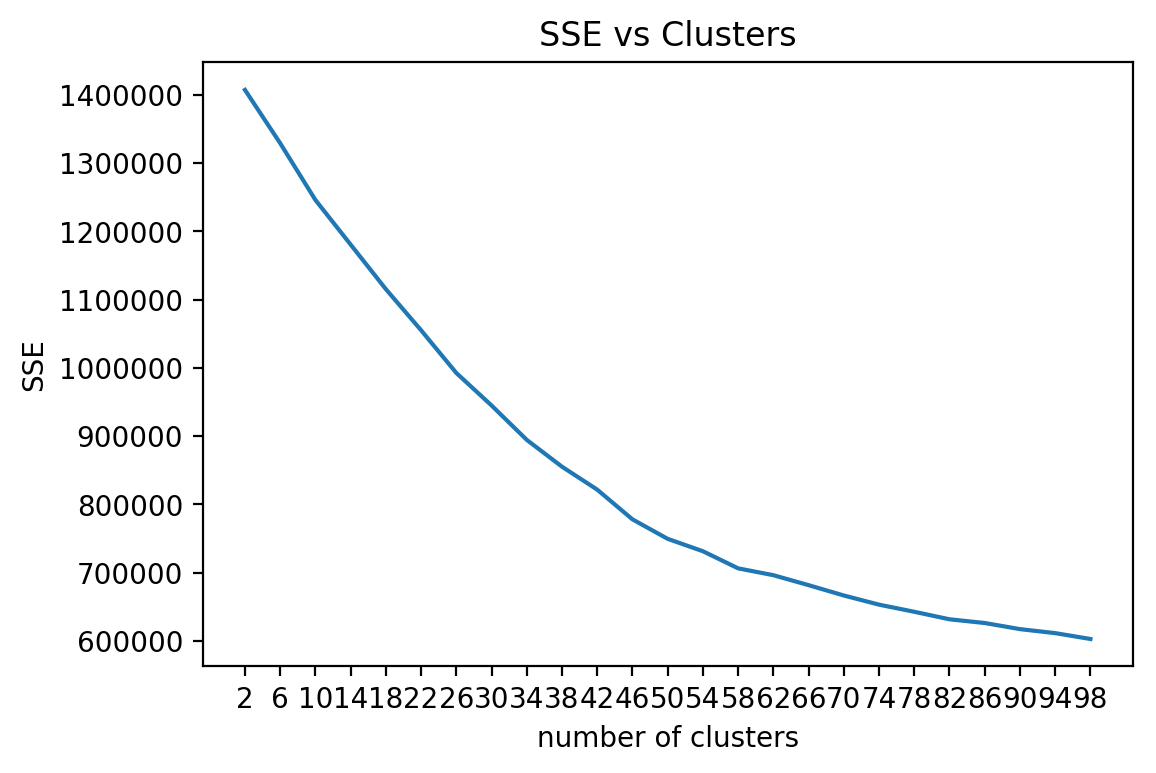

In [44]:
k_clusters = range(2,100,4)
plt.figure(dpi=200)

# plot Intertia/SSE on ax2
plt.plot(k_clusters, SSEs)
plt.xlabel('number of clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(2, 100, step=4));
plt.title ('SSE vs Clusters')

Text(0.5,1,'SSE vs Google Clusters')

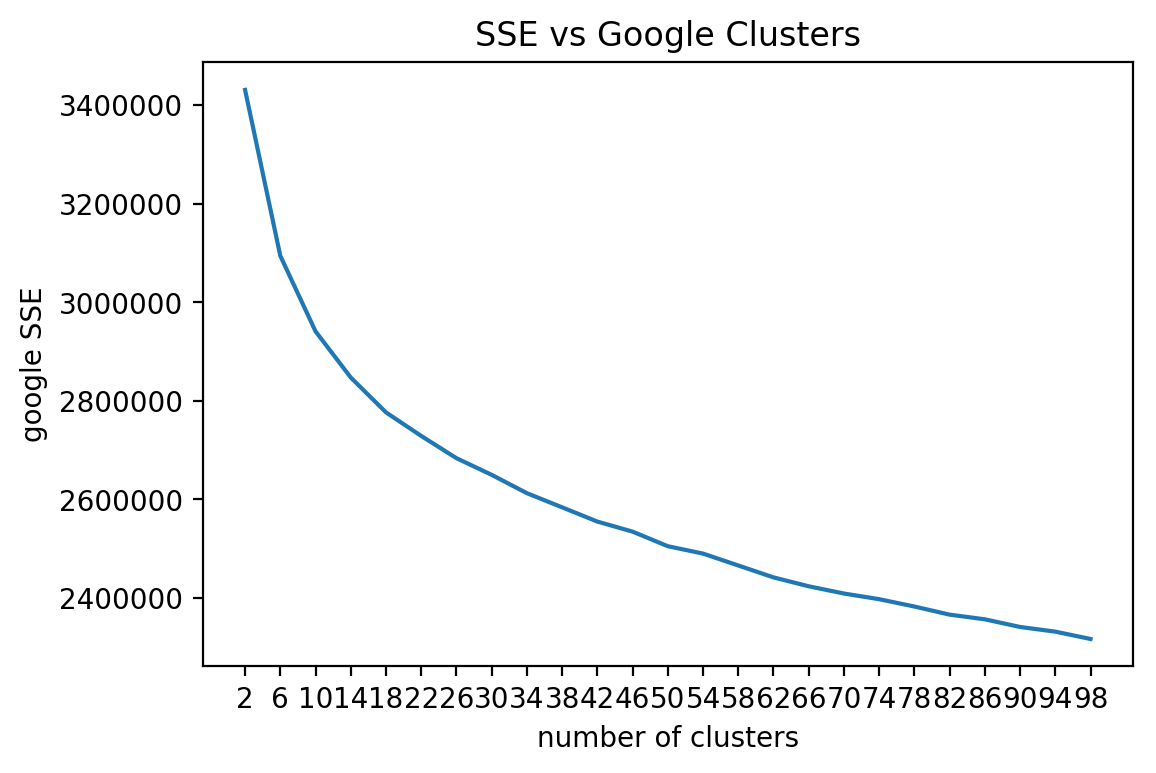

In [47]:
k_clusters = range(2,100,4)
plt.figure(dpi=200)

# plot Intertia/SSE on ax2
plt.plot(k_clusters, google_SSEs)
plt.xlabel('number of clusters')
plt.ylabel('google SSE')
plt.xticks(np.arange(2, 100, step=4));
plt.title ('SSE vs Google Clusters')

In [ ]:
km = KMeans(n_clusters=46)
ypred = km.fit_predict(X)
plt.figure(dpi=200)
plt.scatter(X[:,0],X[:,1],c=plt.cm.rainbow(ypred*20),s=14);

In [18]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 28787 samples in 0.085s...
[t-SNE] Computed neighbors for 28787 samples in 93.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28787
[t-SNE] Computed conditional probabilities for sample 2000 / 28787
[t-SNE] Computed conditional probabilities for sample 3000 / 28787
[t-SNE] Computed conditional probabilities for sample 4000 / 28787
[t-SNE] Computed conditional probabilities for sample 5000 / 28787
[t-SNE] Computed conditional probabilities for sample 6000 / 28787
[t-SNE] Computed conditional probabilities for sample 7000 / 28787
[t-SNE] Computed conditional probabilities for sample 8000 / 28787
[t-SNE] Computed conditional probabilities for sample 9000 / 28787
[t-SNE] Computed conditional probabilities for sample 10000 / 28787
[t-SNE] Computed conditional probabilities for sample 11000 / 28787
[t-SNE] Computed conditional probabilities for sample 12000 / 28787
[t-SNE] Computed conditional probabilities for s

KeyboardInterrupt: 

In [259]:
with open('./data/processed/X_embedded.pkl', 'wb') as picklefile:
    pickle.dump(X_embedded, picklefile)

In [4]:
with open('./data/processed/X_embedded.pkl', 'rb') as picklefile:
    X_embedded = pickle.load(picklefile)

In [ ]:
plt.figure(dpi=250)
plt.title("TSNE FOR LSA TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], ypred,
               size = 2, palette = 'rainbow', alpha = 'auto',
              markers = '.', legend="full");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);